In [53]:
from pathlib import Path
import sys
import json
project_root = Path.cwd().parent   
sys.path.append(str(project_root / "src"))
import matplotlib.pyplot as plt

In [54]:
#!pip install pyvis jinja2 --quiet

In [55]:
from pyvis.network import Network

In [56]:
DATA_DIR_RAW = project_root / "data" / "raw"
DATA_DIR_PROCESSED = project_root / "data" / "processed"

In [57]:
with open(DATA_DIR_PROCESSED /"entities.json", "r", encoding="utf-8") as f:
    entities = json.load(f)
with open(DATA_DIR_PROCESSED /"relationships.json", "r", encoding="utf-8") as f:
    relationships = json.load(f)

In [59]:
output_file = Path("output/entity_relationship_net.html")

# Get all unique types
all_types = list({ent.get("type", "Other") for ent in entities})

# Generate a color map automatically
colors = plt.cm.tab20.colors  # RGB tuples
type_colors = {typ: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" 
               for typ, (r, g, b) in zip(all_types, colors)}


# Create PyVis network
net = Network(height="750px", width="100%", notebook=True, directed=True)

# Add nodes with automatic color assignment
for ent in entities:
    ent_type = ent.get("type", "Other")
    color = type_colors.get(ent_type, "#cccccc")  # fallback color
    aliases = ", ".join(ent.get("aliases", []))
    net.add_node(ent["id"], label=ent["name"], title=f"{ent_type}\nAliases: {aliases}", color=color)

# Add edges
for rel in relationships:
    net.add_edge(rel["source"], rel["target"], label=rel["relation"], title=rel["relation"])

# Show network
net.show(str(output_file))
print(f"Interactive network saved to {output_file}")


output\entity_relationship_net.html
Interactive network saved to output\entity_relationship_net.html


Most interesting node: Sherlock Holmes


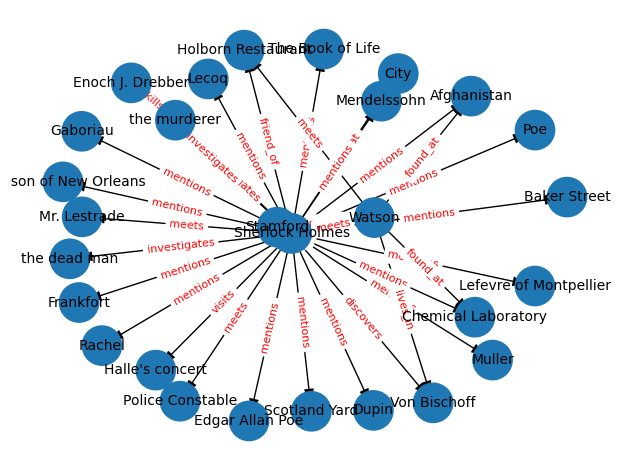

Saved focused network image as 'output/focused_network.png'


In [60]:
import networkx as nx
import matplotlib.pyplot as plt

# Build NetworkX graph
G = nx.DiGraph()
for ent in entities:
    G.add_node(ent["id"], label=ent["name"], type=ent.get("type", "Other"))

for rel in relationships:
    G.add_edge(rel["source"], rel["target"], relation=rel["relation"])

# Compute node importance (degree centrality)
deg_centrality = nx.degree_centrality(G)
most_interesting_node = max(deg_centrality, key=deg_centrality.get)
print("Most interesting node:", G.nodes[most_interesting_node]["label"])

# Extract subgraph: node + its neighbors
neighbors = list(G.successors(most_interesting_node)) + list(G.predecessors(most_interesting_node))
sub_nodes = neighbors + [most_interesting_node]
subG = G.subgraph(sub_nodes)

# Generate layout
pos = nx.spring_layout(subG, seed=42)  # or nx.circular_layout(subG)

# Color nodes by type
all_types = list({subG.nodes[n].get("type", "Other") for n in subG.nodes})
colors_palette = plt.cm.tab20.colors
type_color_map = {typ: colors_palette[i % len(colors_palette)] for i, typ in enumerate(all_types)}
node_colors = [type_color_map[subG.nodes[n].get("type", "Other")] for n in subG.nodes]

# Draw nodes
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=800)
nx.draw_networkx_labels(subG, pos, labels={n: subG.nodes[n]["label"] for n in subG.nodes}, font_size=10)

# Draw edges with labels
nx.draw_networkx_edges(subG, pos, arrowstyle='-|>', arrowsize=15)
edge_labels = {(u, v): d["relation"] for u, v, d in subG.edges(data=True)}
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Remove axis
plt.axis("off")
plt.tight_layout()

# Save as PNG
plt.savefig("output/focused_network.png", dpi=300)
plt.show()
print("Saved focused network image as 'output/focused_network.png'")
